In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
import seaborn as sn
import numpy as np
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR,NuSVR,LinearSVR
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,BayesianRidge,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.svm import NuSVR
from sklearn.impute import KNNImputer
import joblib

### import dataset

In [2]:
df=pd.read_csv('Advertising.csv')
df

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


In [3]:
df.columns

Index(['Unnamed: 0', 'TV', 'radio', 'newspaper', 'sales'], dtype='object')

In [4]:
df['Unnamed: 0'].value_counts()

1      1
138    1
128    1
129    1
130    1
      ..
70     1
71     1
72     1
73     1
200    1
Name: Unnamed: 0, Length: 200, dtype: int64

### unnamed: 0 is just an index column drop it

In [5]:
df=df.drop(['Unnamed: 0'],axis=1)
df

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


In [6]:
print('Number of rows x columns in dataset are:',df.shape)

Number of rows x columns in dataset are: (200, 4)


In [7]:
print('Dataset contains any null values:',df.isnull().values.any())

Dataset contains any null values: False


In [8]:
df.dtypes

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object

### sales is our target variable. remaining are independent variable

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


### using info func we gained insight on the dtype of columns

### now use describe func and analyze both dataset

In [10]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


### check correlation of dataset

In [11]:
df.corr()['sales']

TV           0.782224
radio        0.576223
newspaper    0.228299
sales        1.000000
Name: sales, dtype: float64

### use heatmap to check correlation on dataset

<AxesSubplot:>

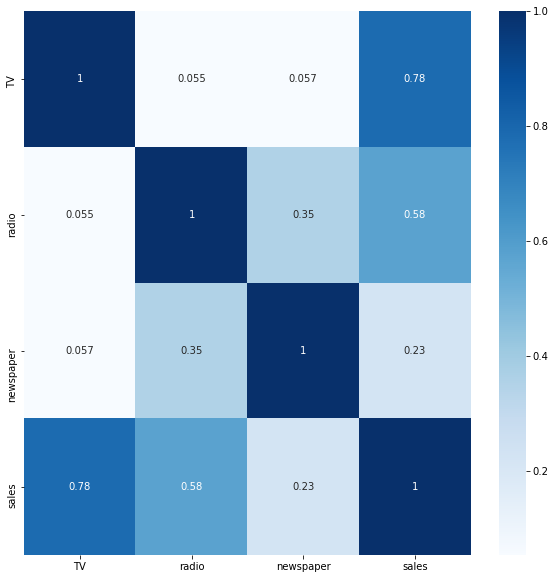

In [12]:
plt.figure(figsize=[10,10])
sn.heatmap(df.corr(),annot=True,cmap='Blues')

### newspaper has least correlation but use further plots to decide whether to drop newspaper column or not.

### check dist plots of train dataset

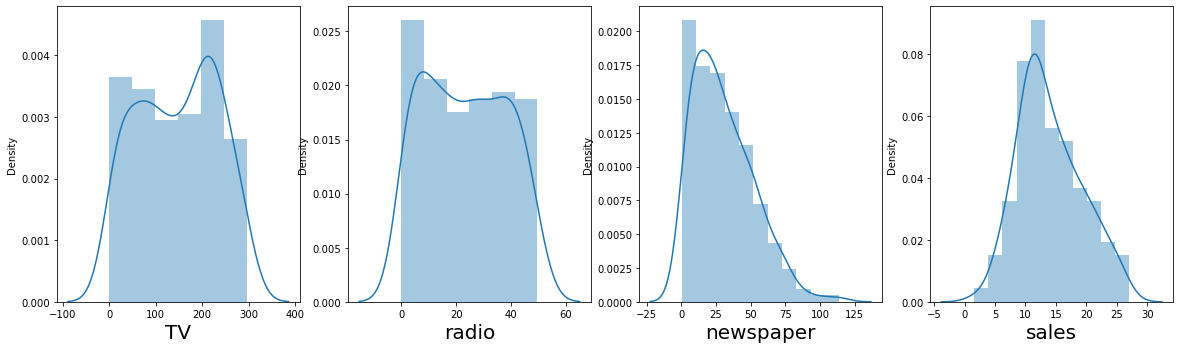

In [13]:
plt.figure(figsize=(20,25),facecolor='white')
plotnumber=1
for column in df.columns:
    if plotnumber<=12:
        ax=plt.subplot(4,4,plotnumber)
        sn.distplot(df[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.show()

### newspaper and sales column have normal dist plot. newspaper has positive bias in it. tv is a bimodal plot. radio is close to rectangular plot

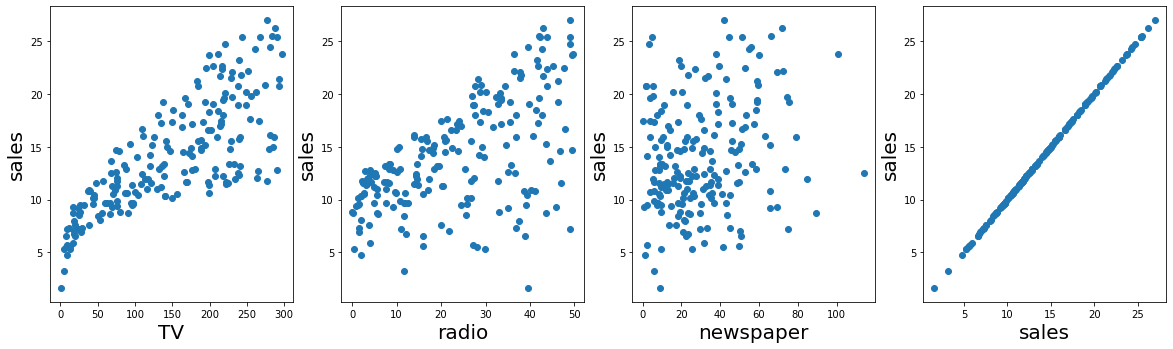

In [14]:
plt.figure(figsize=(20,25),facecolor='white')
plotnumber=1
for i in df.columns:
    if plotnumber<=12:
        ax=plt.subplot(4,4,plotnumber)
        plt.scatter(df[i],df['sales'])
        plt.xlabel(i,fontsize=20)
        plt.ylabel('sales',fontsize=20)
    plotnumber+=1
plt.show()

### tv and radio have proper linear relation with sales column. newspaper datapoints are scattered with respect to sales column

### based on correlation and above plots. i have decided to drop newspaper column

In [15]:
df=df.drop(['newspaper'],axis=1)
df

,TV,radio,sales
0,230.1,37.8,22.1
1,44.5,39.3,10.4
2,17.2,45.9,9.3
3,151.5,41.3,18.5
4,180.8,10.8,12.9
...,...,...,...
195,38.2,3.7,7.6
196,94.2,4.9,9.7
197,177.0,9.3,12.8
198,283.6,42.0,25.5


### check outliers

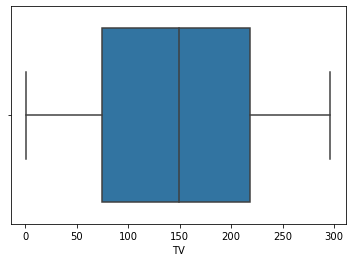

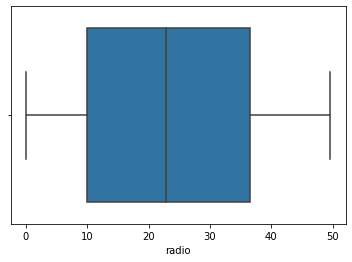

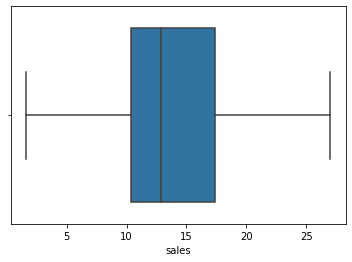

In [16]:
for i in df.columns:
    sn.boxplot(df[i])
    plt.show()

### no outliers are present

### check multicollinearity

In [17]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(df.drop(['sales'],axis=1).values,i) for i in range(df.drop(['sales'],axis=1).shape[1])]
vif["Features"] = df.drop(['sales'],axis=1).columns
vif

,vif,Features
0,2.238085,TV
1,2.238085,radio


### looks good no multicollinearity present

In [18]:
y = df[['sales']]
x = df.drop(columns = ['sales'],axis=1)

### check biasing and remove if present else proceed

In [19]:
print(x.skew())
print()
print(len(x.skew().loc[x.skew()>0.55]))

TV      -0.069853
radio    0.094175
dtype: float64

0


### feature scaling

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

### no need to apply pca here s there is already very less columns and datapoints present

### iterate to find best model, best random state and most effective hyper parameters

In [21]:
models=[GradientBoostingRegressor(),NuSVR(),LinearRegression(),Ridge(),RidgeCV(),BayesianRidge(),SGDRegressor(),SVR(),
        AdaBoostRegressor(),LinearSVR(),KNeighborsRegressor(),RandomForestRegressor(),BaggingRegressor(),
       DecisionTreeRegressor()]

In [22]:
for i in models:
    x_train,x_test,y_train,y_test=train_test_split(X_scaled,y,random_state = 42,test_size=0.20)
    scores=cross_val_score(i,x_train,y_train,cv=5,scoring='r2')
    score=np.mean(scores)
    i.fit(x_train,y_train)
    y_pred=i.predict(x_test)
    if r2_score(y_test,y_pred)>score:
        diff=r2_score(y_test,y_pred)-score
    else:
        diff=score-r2_score(y_test,y_pred)
    print('*'*10)
    print(i)
    print('score',score)
    print('r2',r2_score(y_test,y_pred))
    print('diff',diff)

**********
GradientBoostingRegressor()
score 0.9714116751518457
r2 0.9873710418364502
diff 0.015959366684604515
**********
NuSVR()
score 0.9287145313424727
r2 0.9621789675283923
diff 0.033464436185919544
**********
LinearRegression()
score 0.8626544466104005
r2 0.9005833101920356
diff 0.037928863581635164
**********
Ridge()
score 0.8628478790966622
r2 0.9000861054438107
diff 0.03723822634714857
**********
RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
score 0.8626797833134798
r2 0.9005360756945946
diff 0.037856292381114764
**********
BayesianRidge()
score 0.8626738380617528
r2 0.9004677993044107
diff 0.03779396124265788
**********
SGDRegressor()
score 0.8622235443313315
r2 0.9010472585917711
diff 0.038823714260439623
**********
SVR()
score 0.9295395056381178
r2 0.967206177144627
diff 0.03766667150650915
**********
AdaBoostRegressor()
score 0.9488207330179893
r2 0.9616439656216742
diff 0.012823232603684898
**********
LinearSVR()
score 0.8538208164136201
r2 0.8918642587283887
diff 0.038043442

### KNeighbor regressor has least diff between model score and predict score. Hence use KNeighbor model

In [23]:
parameters={"n_neighbors":range(1,30),'weights':['uniform', 'distance'],'algorithm':['auto', 'ball_tree', 'kd_tree','brute']}
clf = GridSearchCV(KNeighborsRegressor(), parameters, cv=5,scoring="r2")
clf.fit(X_scaled,y)
clf.best_params_

{'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}

In [24]:
def besttrain(model,x,y):
    random=0
    score=0
    for i in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,random_state = i,test_size=0.20,shuffle=True)
        model.fit(x_train,y_train)
        tmp=r2_score(y_test,model.predict(x_test))
        if tmp>score:
            score=tmp
            random=i
    return random

In [25]:
besttrain(KNeighborsRegressor(n_neighbors=4,algorithm='auto',weights='distance'),X_scaled,y)

79

In [26]:
x_train,x_test,y_train,y_test=train_test_split(X_scaled, y,random_state = 79,test_size=0.20,shuffle=True)
model=KNeighborsRegressor(n_neighbors=4,algorithm='auto',weights='distance')
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
score=r2_score(y_test,y_pred)
print('coeff of determination is:',score)
print('mean absolute error:',mean_absolute_error(y_test,y_pred))
print('mean squared error:',mean_squared_error(y_test,y_pred))
print('root mean square error:',np.sqrt(mean_squared_error(y_test,y_pred)))
scores =cross_val_score(model,x,y,cv=5)
print('cross val score',scores.mean())
print('std err',scores.std())

coeff of determination is: 0.9912040893510085
mean absolute error: 0.37624931590459165
mean squared error: 0.23678541990087928
root mean square error: 0.48660602123368685
cross val score 0.9695969090474799
std err 0.010817153653470205


### we can observe the model accuracy to be at 99%. mae:3.7%.mse:2.36%.cross val score:96.95%
### plot appropriate graph to check how similar are y_test and y_pred values

In [27]:
dfd=pd.DataFrame(x_test)
dfd

,0,1
0,1.350518,0.373810
1,0.442057,1.393416
2,0.855419,1.737786
3,-1.383039,-1.469583
4,1.665794,1.285378
5,-0.617035,-1.240003
6,-0.313437,-0.247406
7,1.478964,0.380563
8,1.379711,-1.375050
9,0.676763,1.474444


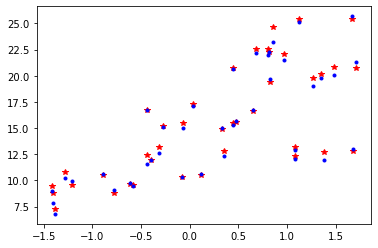

In [28]:
plt.plot(dfd[0],y_test,'r*')
plt.plot(dfd[0],y_pred,'b.')

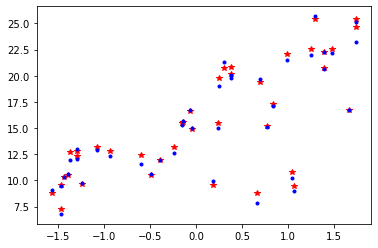

In [29]:
plt.plot(dfd[1],y_test,'r*')
plt.plot(dfd[1],y_pred,'b.')

### plots of ypred is very similar to plot of ytest. they are almost at the same points.this confirms the acc of model 

### save model

In [30]:
joblib.dump(model,'Advertising.pkl')

['Advertising.pkl']